# Results - Classification on simulated events
This notebook is the primary source of plots and tables for the classificationn part of the thesis, 
with the goal of keeping every table and figure as standardized as possible. (And who has the time to update 90 tables one by one anyway).

## Questions
* Descriptive statistics
    - Should descriptive statistics of the simulated data be included?\
    If so, how much? And should it be included for each fold in the k-fold cross-validation?
* Classification results
    - Breakdown of results based on event type? Single, double, close double?
    Reasonable to include in order to confirm the assumption that close doubles are the
    most difficult event type to classify correctly in simulated data
    Random state is included, so should be simple to reproduce the indices

## Handy links
* [matplotlib-plots to latex](https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/)
* [Robert's thesis df output](https://github.com/ATTPC/VAE-event-classification/blob/master/src/make_classification_table.py)

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from master_scripts.data_functions import get_git_root, normalize_image_data, event_indices
from master_scripts.analysis_functions import load_experiment, experiment_metrics_to_df
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, matthews_corrcoef, accuracy_score
import tensorflow as tf
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

THESIS_PATH = "../../../master_thesis/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Load test set and normalize
repo_root = get_git_root()
test_images = np.load(repo_root + "data/simulated/test/" + "images_test.npy")
test_images = normalize_image_data(test_images)
test_positions = np.load(repo_root + "data/simulated/test/" + "positions_test.npy") 
test_energies = np.load(repo_root + "data/simulated/test/" + "energies_test.npy") 
test_labels = np.load(repo_root + "data/simulated/test/" + "labels_test.npy") 

In [12]:
def classification_metrics(model, test_images, test_labels, name):
    # Get prediction and make class labels based on threshold of 0.5
    y_out = model.predict(test_images)
    y_pred = y_out > 0.5
    confmat = confusion_matrix(test_labels, y_pred)

    metrics = {}
    metrics['accuracy_score'] = accuracy_score(test_labels, y_pred)
    metrics['f1_score'] = f1_score(test_labels, y_pred)
    metrics['matthews_corrcoef'] = matthews_corrcoef(test_labels, y_pred)
    metrics['roc_auc_score'] = roc_auc_score(test_labels, y_out)
    metrics['TN'] = int(confmat[0, 0])
    metrics['FP'] = int(confmat[0, 1])
    metrics['FN'] = int(confmat[1, 0])
    metrics['TP'] = int(confmat[1, 1])
    
    df = pd.DataFrame.from_dict(data={name: metrics}, orient='index')
    return df


In [13]:
# Experiment id's
experiments_nomod = {
    'logistic': "1bc7c249cd14",
    'dense': "301dfb138506",
    'cnn': "7f2dd7f1d24c",
    'pretrained': "94685622cb2d",
    'custom': "e8772df34916",
}
experiments_pixelmod = {
    'logistic': "292d34a807ea",
    'dense': "48203947802a",
    'cnn': "35afebe71164",
    'pretrained': "6aebbcd131d1",
    'custom': "05b90ffdfc3c",
}
experiments_imbalanced = {
    'logistic': "9380b00c72f5",
    'dense': "851d3c6f60c8",
    'cnn': "d34250436c72",
    'pretrained': "dd1df8beb788",
    'custom': "28fd163fc0c1",
}

# Pre-processed simulated data - no additional modifications
This is the basic metrics for all the models trained on simulated data.
The basic pre-processing includes formatting and min-max normalization.

## Logistic regression

In [14]:
# Load logistic regression experiment
log_ex_id = experiments_nomod['logistic']
log_ex = load_experiment(log_ex_id)

# Load model and predict
log_model = tf.keras.models.load_model(repo_root + "models/" + log_ex_id + ".h5", compile=False)
log_test = classification_metrics(log_model, test_images.reshape(test_images.shape[0], 256), test_labels, "log_test")
del log_model #No longer needed, clear memory just in case.

log_metrics = experiment_metrics_to_df(log_ex)
#display(log_metrics)
log_means = log_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
log_means = log_means.rename(index={'mean': 'log_mean', 'std': 'log_std'})
#display(log_means)

## Small dense network

In [16]:
# Load logistic regression experiment
#dense_ex_id = "c19117f62bd8"
dense_ex_id = experiments_nomod['dense']
dense_ex = load_experiment(dense_ex_id)
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test = classification_metrics(dense_model, test_images.reshape(test_images.shape[0], 256), test_labels, "dense_test")
del dense_model

dense_metrics = experiment_metrics_to_df(dense_ex)
#display(dense_metrics)
dense_means = dense_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
dense_means = dense_means.rename(index={'mean': 'dense_mean', 'std': 'dense_std'})
#display(dense_means)

## Small CNN

In [17]:
# Load logistic regression experiment
#cnn_ex_id = "b56e64ac3b1c"
cnn_ex_id = experiments_nomod['cnn']
cnn_ex = load_experiment(cnn_ex_id)
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test = classification_metrics(cnn_model, test_images, test_labels, "cnn_test")
del cnn_model

cnn_metrics = experiment_metrics_to_df(cnn_ex)
#display(cnn_metrics)
cnn_means = cnn_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
cnn_means = cnn_means.rename(index={'mean': 'cnn_mean', 'std': 'cnn_std'})
#display(cnn_means)

## Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes and issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [18]:
# Load pretrained regression experiment 9af4dc6778f3
#pretrained_ex_id = "c96f61c743c2"
pretrained_ex_id = experiments_nomod['pretrained']
pretrained_ex = load_experiment(pretrained_ex_id)

pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test = classification_metrics(pretrained_model, np.concatenate((test_images, test_images, test_images), axis=-1), test_labels, "pretrained_test")
del pretrained_model

pretrained_metrics = experiment_metrics_to_df(pretrained_ex)
#display(pretrained_metrics)
pretrained_means = pretrained_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
pretrained_means = pretrained_means.rename(index={'mean': 'pretrained_mean', 'std': 'pretrained_std'})
#display(pretrained_means)

## Custom model

In [19]:
# Load custom classification experiment 7d030c84f483
#custom_ex_id = "424cc250c5ab"
custom_ex_id = experiments_nomod['custom']
custom_ex = load_experiment(custom_ex_id)
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test = classification_metrics(custom_model, test_images, test_labels, "custom_test")
del custom_model

custom_metrics = experiment_metrics_to_df(custom_ex)
#display(custom_metrics)
custom_means = custom_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
custom_means = custom_means.rename(index={'mean': 'custom_mean', 'std': 'custom_std'})
#display(custom_means)

## Combine the metrics into one table
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [20]:
all_means = pd.DataFrame(
    [
        log_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_mean': 'Logistic',
        'dense_mean': 'Dense',
        'cnn_mean': 'CNN',
        'pretrained_mean': 'Pretrained',
        'custom_mean': 'Custom',
    }
)

all_std = pd.DataFrame(
    [
        log_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_std': 'Logistic',
        'dense_std': 'Dense',
        'cnn_std': 'CNN',
        'pretrained_std': 'Pretrained',
        'custom_std': 'Custom'
    }
)

all_test = pd.DataFrame(
    [
        log_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_test': 'Logistic',
        'dense_test': 'Dense',
        'cnn_test': 'CNN',
        'pretrained_test': 'Pretrained',
        'custom_test': 'Custom',
    }
)

#display(all_means)
display(all_std)
display(all_test)

,f1_score,roc_auc_score,TN,FP,FN,TP
Logistic,0.007528,0.000965,16671.068853,16597.498104,11724.980542,11798.783954
Dense,0.038372,0.032809,14272.299401,14097.774427,7321.257508,7426.508682
CNN,0.014745,0.014472,10268.162762,10187.917191,12207.228912,12290.347749
Pretrained,0.434833,0.219663,1480.241129,1441.388463,81498.555194,81314.591655
Custom,0.023735,0.024535,10835.469611,10692.506254,973.786938,1063.255943


,f1_score,roc_auc_score,TN,FP,FN,TP
Logistic,0.738100,0.832023,32489.0,17452.0,10571.0,39488.0
Dense,0.840112,0.922879,41769.0,8172.0,7882.0,42177.0
CNN,0.916584,0.961412,46567.0,3374.0,4854.0,45205.0
Pretrained,0.969616,0.990148,49014.0,927.0,2080.0,47979.0
Custom,0.968786,0.988087,47967.0,1974.0,1176.0,48883.0


### Output combined frames to latex
Make one table for f1-scores, one for roc auc scores.

In [21]:
rows = all_test.index
f1_auc_str_array = np.zeros((2, all_test.shape[0]), dtype=object)
#auc_str_array = np.zeros((1, all_means.shape[0]), dtype=object)
for i in range(all_means.shape[0]):
    f1_auc_str_array[0, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std["f1_score"][i], all_test["f1_score"][i])
    f1_auc_str_array[1, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std['roc_auc_score'][i], all_test['roc_auc_score'][i])
        
#f1_df = pd.DataFrame(f1_str_array, columns=rows)
#auc_df = pd.DataFrame(auc_str_array, columns=rows)
f1_auc_df = pd.DataFrame(f1_auc_str_array, columns=rows, index=['F1-score', 'AUC'])

section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "classification_simulated_f1_auc.tex"
caption = """
Test set F1-scores and roc-auc scores for classification of simulated data using multiple models. 
Error estimates are the standard deviation in results from k-fold cross-validation 
with $K=5$ folds.
"""
label = "tab:classification-simulated-f1-auc"
with open(fname, "w") as fp:
    pd.set_option('display.max_colwidth', -1)
    f1_auc_df.to_latex(fp, escape=False, caption=caption, label=label, index=True)


# Pre-processed simulated data - Pixel modified
The basic pre-processing includes formatting and min-max normalization.
Additionally, the data has had the top and bottom lines of pixels set to 0, plus
one pixel inside the detector permanently 0 (which idx again?).

## Logistic regression

In [22]:
# Load logistic regression experiment 
#log_ex_id = "b89547da983e"
log_ex_id = experiments_pixelmod['logistic']
log_ex = load_experiment(log_ex_id)

# Load model
log_model = tf.keras.models.load_model(repo_root + "models/" + log_ex_id + ".h5", compile=False)
log_test = classification_metrics(log_model, test_images.reshape(test_images.shape[0], 256), test_labels, "log_test")
del log_model #No longer needed, clear memory just in case.

log_metrics = experiment_metrics_to_df(log_ex)
#display(log_metrics)
log_means = log_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
log_means = log_means.rename(index={'mean': 'log_mean', 'std': 'log_std'})
#display(log_means)

## Small dense network

In [23]:
# Load logistic regression experiment 
#dense_ex_id = "bc4937925065"
dense_ex_id = experiments_pixelmod['dense']
dense_ex = load_experiment(dense_ex_id)
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test = classification_metrics(dense_model, test_images.reshape(test_images.shape[0], 256), test_labels, "dense_test")
del dense_model

dense_metrics = experiment_metrics_to_df(dense_ex)
#display(dense_metrics)
dense_means = dense_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
dense_means = dense_means.rename(index={'mean': 'dense_mean', 'std': 'dense_std'})
#display(dense_means)

## Small CNN

In [24]:
# Load logistic regression experiment 
#cnn_ex_id = "2b135384dd50"
cnn_ex_id = experiments_pixelmod['cnn']
cnn_ex = load_experiment(cnn_ex_id)
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test = classification_metrics(cnn_model, test_images, test_labels, "cnn_test")
del cnn_model

cnn_metrics = experiment_metrics_to_df(cnn_ex)
#display(cnn_metrics)
cnn_means = cnn_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
cnn_means = cnn_means.rename(index={'mean': 'cnn_mean', 'std': 'cnn_std'})
#display(cnn_means)

## Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes and issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [25]:
# Load logistic regression experiment 
#pretrained_ex_id = "6bc44ed76ea7"
pretrained_ex_id = experiments_pixelmod['pretrained']
pretrained_ex = load_experiment(pretrained_ex_id)
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test = classification_metrics(pretrained_model, np.concatenate((test_images, test_images, test_images), axis=-1), test_labels, "pretrained_test")
del pretrained_model

pretrained_metrics = experiment_metrics_to_df(pretrained_ex)
#display(pretrained_metrics)
pretrained_means = pretrained_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
pretrained_means = pretrained_means.rename(index={'mean': 'pretrained_mean', 'std': 'pretrained_std'})
#display(pretrained_means)

## Custom model

In [26]:
# Load custom classification experiment 
#custom_ex_id = "60f95ed56212"
custom_ex_id = experiments_pixelmod['custom']
custom_ex = load_experiment(custom_ex_id)
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test = classification_metrics(custom_model, test_images, test_labels, "custom_test")
del custom_model

custom_metrics = experiment_metrics_to_df(custom_ex)
#display(custom_metrics)
custom_means = custom_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
custom_means = custom_means.rename(index={'mean': 'custom_mean', 'std': 'custom_std'})
#display(custom_means)

## Combine the metrics into one table
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [27]:
all_means_pmod = pd.DataFrame(
    [
        log_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_mean': 'Logistic',
        'dense_mean': 'Dense',
        'cnn_mean': 'CNN',
        'pretrained_mean': 'Pretrained',
        'custom_mean': 'Custom',
    }
)

all_std_pmod = pd.DataFrame(
    [
        log_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_std': 'Logistic',
        'dense_std': 'Dense',
        'cnn_std': 'CNN',
        'pretrained_std': 'Pretrained',
        'custom_std': 'Custom',
    }
)

all_test_pmod = pd.DataFrame(
    [
        log_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_test': 'Logistic',
        'dense_test': 'Dense',
        'cnn_test': 'CNN',
        'pretrained_test': 'Pretrained',
        'custom_test': 'Custom',
    }
)
#display(all_means_pmod)
display(all_test_pmod)
display(all_std_pmod)

,f1_score,roc_auc_score,TN,FP,FN,TP
Logistic,0.732653,0.831576,36146.0,13795.0,13145.0,36914.0
Dense,0.732372,0.831235,36244.0,13697.0,13224.0,36835.0
CNN,0.796111,0.946442,26505.0,23436.0,1458.0,48601.0
Pretrained,0.965823,0.985726,49164.0,777.0,2583.0,47476.0
Custom,0.932253,0.981545,43710.0,6231.0,912.0,49147.0


,f1_score,roc_auc_score,TN,FP,FN,TP
Logistic,0.002298,0.000980,6972.081203,7070.104865,4780.762209,4695.159603
Dense,0.074529,0.053307,19682.604736,19431.709176,10667.838614,10475.915344
CNN,0.023097,0.005335,6608.531039,6839.749023,10010.392914,10006.859033
Pretrained,0.003070,0.002531,1291.352005,1331.025807,1477.299665,1357.030692
Custom,0.007587,0.001364,3435.141511,3470.740598,529.181727,651.955290


### Output combined frame to latex

In [28]:
rows = all_test_pmod.index
f1_auc_str_array = np.zeros((2, all_test_pmod.shape[0]), dtype=object)
#auc_str_array = np.zeros((1, all_means.shape[0]), dtype=object)
for i in range(all_test_pmod.shape[0]):
    f1_auc_str_array[0, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std_pmod["f1_score"][i], all_test_pmod["f1_score"][i])
    f1_auc_str_array[1, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std_pmod['roc_auc_score'][i], all_test_pmod['roc_auc_score'][i])
        
#f1_df = pd.DataFrame(f1_str_array, columns=rows)
#auc_df = pd.DataFrame(auc_str_array, columns=rows)
f1_auc_df = pd.DataFrame(f1_auc_str_array, columns=rows, index=['F1-score', 'AUC'])

section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "classification_simulated_pixelmod_f1_auc.tex"
caption = """
Test set F1-scores and roc-auc scores for classification of simulated data with specific pixels
modified, using multiple models. Error estimates are the standard deviation in results from 
k-fold cross-validation with $K=5$ folds.
"""
label = "tab:classification-simulated-pixelmod-f1-auc"
with open(fname, "w") as fp:
    pd.set_option('display.max_colwidth', -1)
    f1_auc_df.to_latex(fp, escape=False, caption=caption, label=label, index=True)


# Pre-processed simulated data - Pixel modified and imbalanced
The basic pre-processing includes formatting and min-max normalization.
Additionally, the data has had the top and bottom lines of pixels set to 0, plus
one pixel inside the detector permanently 0 (which idx again?).

This dataset has also been purposefully imbalanced to mimic the properties of experimental data
where doubles in space are expected to be rare.

## Logistic regression

In [29]:
# Load logistic regression experiment 
#log_ex_id = "f7f88d576358"
log_ex_id = experiments_imbalanced['logistic']
log_ex = load_experiment(log_ex_id)

# Load model
log_model = tf.keras.models.load_model(repo_root + "models/" + log_ex_id + ".h5", compile=False)
log_test = classification_metrics(log_model, test_images.reshape(test_images.shape[0], 256), test_labels, "log_test")
del log_model #No longer needed, clear memory just in case.

log_metrics = experiment_metrics_to_df(log_ex)
display(log_metrics)
log_means = log_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
log_means = log_means.rename(index={'mean': 'log_mean', 'std': 'log_std'})
#display(log_means)

,accuracy_score,f1_score,matthews_corrcoef,roc_auc_score,TN,FP,FN,TP
fold_0,0.970403,0.550301,0.606700,0.832535,189995,1,5904,3613
fold_1,0.968453,0.512244,0.577288,0.830283,189913,0,6294,3305
fold_2,0.963691,0.374223,0.470884,0.832799,190102,0,7244,2166
fold_3,0.972067,0.593360,0.636279,0.832392,189873,79,5494,4066
fold_4,0.967080,0.464449,0.540706,0.834796,190096,0,6568,2848


## Small dense network

In [30]:
# Load logistic regression experiment
#dense_ex_id = "eda9d70f103d"
dense_ex_id = experiments_imbalanced['dense']
dense_ex = load_experiment(dense_ex_id)
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test = classification_metrics(dense_model, test_images.reshape(test_images.shape[0], 256), test_labels, "dense_test")
del dense_model

dense_metrics = experiment_metrics_to_df(dense_ex)
#display(dense_metrics)
dense_means = dense_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
dense_means = dense_means.rename(index={'mean': 'dense_mean', 'std': 'dense_std'})
#display(dense_means)

## Small CNN

In [31]:
# Load logistic regression experiment
#cnn_ex_id = "fbec3ae91aaa"
cnn_ex_id = experiments_imbalanced['cnn']
cnn_ex = load_experiment(cnn_ex_id)
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test = classification_metrics(cnn_model, test_images, test_labels, "cnn_test")
del cnn_model

cnn_metrics = experiment_metrics_to_df(cnn_ex)
#display(cnn_metrics)
cnn_means = cnn_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
cnn_means = cnn_means.rename(index={'mean': 'cnn_mean', 'std': 'cnn_std'})
#display(cnn_means)

## Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes and issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [32]:
# Load logistic regression experiment 
#pretrained_ex_id = "63d7c8bf7564"
pretrained_ex_id = experiments_imbalanced['pretrained']
pretrained_ex = load_experiment(pretrained_ex_id)
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test = classification_metrics(pretrained_model, np.concatenate((test_images, test_images, test_images), axis=-1), test_labels, "pretrained_test")
del pretrained_model

pretrained_metrics = experiment_metrics_to_df(pretrained_ex)
#display(pretrained_metrics)
pretrained_means = pretrained_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
pretrained_means = pretrained_means.rename(index={'mean': 'pretrained_mean', 'std': 'pretrained_std'})
#display(pretrained_means)

## Custom model

In [33]:
# Load custom classification experiment 
#custom_ex_id = "5f6eef7315ab"
custom_ex_id = experiments_imbalanced['custom']
custom_ex = load_experiment(custom_ex_id)
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test = classification_metrics(custom_model, test_images, test_labels, "custom_test")
del custom_model

custom_metrics = experiment_metrics_to_df(custom_ex)
#display(custom_metrics)
custom_means = custom_metrics.agg([np.mean, np.std])#.applymap('{:.3f}'.format)
custom_means = custom_means.rename(index={'mean': 'custom_mean', 'std': 'custom_std'})
#display(custom_means)

## Combine the metrics into one table
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [34]:
all_means_imbalanced = pd.DataFrame(
    [
        log_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_means.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_mean': 'Logistic',
        'dense_mean': 'Dense',
        'cnn_mean': 'CNN',
        'pretrained_mean': 'Pretrained',
        'custom_mean': 'Custom',
    }
)
all_std_imbalanced = pd.DataFrame(
    [
        log_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_means.iloc[1][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_std': 'Logistic',
        'dense_std': 'Dense',
        'cnn_std': 'CNN',
        'pretrained_std': 'Pretrained',
        'custom_std': 'Custom',
    }
)
all_test_imbalanced = pd.DataFrame(
    [
        log_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        dense_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        cnn_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        pretrained_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
        custom_test.iloc[0][['f1_score', 'roc_auc_score', 'TN', 'FP', 'FN', 'TP']],
    ]
).rename(
    index={
        'log_test': 'Logistic',
        'dense_test': 'Dense',
        'cnn_test': 'CNN',
        'pretrained_test': 'Pretrained',
        'custom_test': 'Custom',
    }
)
#display(all_means_imbalanced)
display(all_test_imbalanced)
display(all_std_imbalanced)

,f1_score,roc_auc_score,TN,FP,FN,TP
Logistic,0.294005,0.831563,49941.0,0.0,41432.0,8627.0
Dense,0.301876,0.831351,49941.0,0.0,41160.0,8899.0
CNN,0.831114,0.928854,49929.0,12.0,14457.0,35602.0
Pretrained,0.927535,0.978658,49888.0,53.0,6719.0,43340.0
Custom,0.968290,0.988199,49879.0,62.0,3019.0,47040.0


,f1_score,roc_auc_score,TN,FP,FN,TP
Logistic,0.084371,0.001602,103.988942,35.220733,665.102398,728.801962
Dense,0.089490,0.001509,5583.876610,5574.177895,1125.808598,1168.006122
CNN,0.015347,0.000433,181.188300,124.574476,263.836692,333.134657
Pretrained,0.039483,0.002608,1179.399127,1142.432843,252.491584,306.358940
Custom,0.123817,0.002940,3663.345834,3624.972896,93.812579,160.291921


### Output combined frame to latex

In [35]:
rows = all_test_imbalanced.index
f1_auc_str_array = np.zeros((2, all_means_imbalanced.shape[0]), dtype=object)
#auc_str_array = np.zeros((1, all_means.shape[0]), dtype=object)
for i in range(all_test_imbalanced.shape[0]):
    f1_auc_str_array[0, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std_pmod["f1_score"][i], all_test_imbalanced["f1_score"][i])
    f1_auc_str_array[1, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std_pmod['roc_auc_score'][i], all_test_imbalanced['roc_auc_score'][i])
        
#f1_df = pd.DataFrame(f1_str_array, columns=rows)
#auc_df = pd.DataFrame(auc_str_array, columns=rows)
f1_auc_df = pd.DataFrame(f1_auc_str_array, columns=rows, index=['F1-score', 'AUC'])

section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "classification_simulated_pixelmod_f1_auc.tex"
caption = """
Mean F1-scores and roc-auc scores for classification of simulated data with specific pixels
modified, using multiple models trained on an imbalanced dataset. Error estimates are the 
standard deviation in results from k-fold cross-validation with $K=5$ folds.
"""
label = "tab:classification-simulated-pixelmod-f1-auc"
with open(fname, "w") as fp:
    pd.set_option('display.max_colwidth', -1)
    f1_auc_df.to_latex(fp, escape=False, caption=caption, label=label, index=True)


# Table for all f1 and auc values

In [36]:
rows = all_test_imbalanced.index
f1_auc_str_array_full = np.zeros((3, all_test_imbalanced.shape[0]), dtype=object)
#auc_str_array = np.zeros((1, all_means.shape[0]), dtype=object)
for i in range(f1_auc_str_array_full.shape[1]):
    f1_auc_str_array_full[0, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std["f1_score"][i], all_test["f1_score"][i])
    f1_auc_str_array_full[1, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std_pmod["f1_score"][i], all_test_pmod["f1_score"][i])
    f1_auc_str_array_full[2, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
        all_std_imbalanced["f1_score"][i], all_test_imbalanced["f1_score"][i])
    #f1_auc_str_array_full[3, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
    #    all_std['roc_auc_score'][i], all_test['roc_auc_score'][i])
    #f1_auc_str_array_full[4, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
    #    all_std_pmod['roc_auc_score'][i], all_test_pmod['roc_auc_score'][i])
    #f1_auc_str_array_full[5, i] = r"$\underset{{\num{{+- {:.3e} }}  }}{{\num{{ {:.3g} }} }}$".format(
    #    all_std_imbalanced['roc_auc_score'][i], all_test_imbalanced['roc_auc_score'][i])
        
#f1_df = pd.DataFrame(f1_str_array, columns=rows)
#auc_df = pd.DataFrame(auc_str_array, columns=rows)
index_full = ['F1-score (a)', 'F1-score (b)', 'F1-score (c)']#, 'AUC (a)', 'AUC (b)', 'AUC (c)',]
f1_auc_df_full = pd.DataFrame(f1_auc_str_array_full, columns=rows, index=index_full)

section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "classification_simulated_all_f1_auc.tex"
caption = """
Test set F1-scores for classification of simulated datausing multiple models.
Models are trained on a) unmodified data, b) data where specific pixels are set to zero to mimic
'dead' pixels in experimental data, and c) same as b) and imbalanced to mimic experimental data. 
Error estimates are the standard deviation in results from k-fold cross-validation with $K=5$ folds.
"""
label = "tab:classification-simulated-all-f1-auc"
with open(fname, "w") as fp:
    pd.set_option('display.max_colwidth', -1)
    f1_auc_df_full.to_latex(fp, escape=False, caption=caption, label=label, index=True)


# Confusion matrix for all the sets

### Plot confusion matrix for both data variants in one grid

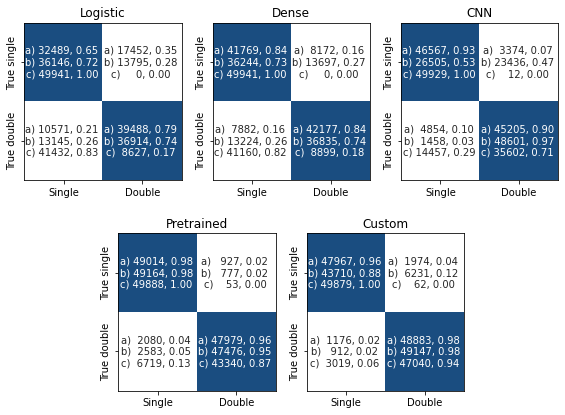

In [37]:
cm_log = all_test.loc['Logistic'][2:].values
cm_dense = all_test.loc['Dense'][2:].values
cm_cnn = all_test.loc['CNN'][2:].values
cm_pretrained = all_test.loc['Pretrained'][2:].values
cm_custom = all_test.loc['Custom'][2:].values

cm_log_pmod = all_test_pmod.loc['Logistic'][2:].values
cm_dense_pmod = all_test_pmod.loc['Dense'][2:].values
cm_cnn_pmod = all_test_pmod.loc['CNN'][2:].values
cm_pretrained_pmod = all_test_pmod.loc['Pretrained'][2:].values
cm_custom_pmod = all_test_pmod.loc['Custom'][2:].values

cm_log_imbalanced = all_test_imbalanced.loc['Logistic'][2:].values
cm_dense_imbalanced = all_test_imbalanced.loc['Dense'][2:].values
cm_cnn_imbalanced = all_test_imbalanced.loc['CNN'][2:].values
cm_pretrained_imbalanced = all_test_imbalanced.loc['Pretrained'][2:].values
cm_custom_imbalanced = all_test_imbalanced.loc['Custom'][2:].values

# Ratio calculations
s_idx, d_idx, c_idx = event_indices(test_positions)
tot_test = np.array([len(s_idx), len(d_idx), len(s_idx), len(d_idx)])
#tot_test = test_images.shape[0]
cm_log_rat = cm_log/tot_test
cm_dense_rat = cm_dense/tot_test
cm_cnn_rat = cm_cnn/tot_test
cm_pretrained_rat = cm_pretrained/tot_test
cm_custom_rat = cm_custom/tot_test

cm_log_pmod_rat = cm_log_pmod/tot_test
cm_dense_pmod_rat = cm_dense_pmod/tot_test
cm_cnn_pmod_rat = cm_cnn_pmod/tot_test
cm_pretrained_pmod_rat = cm_pretrained_pmod/tot_test
cm_custom_pmod_rat = cm_custom_pmod/tot_test

cm_log_imbalanced_rat = cm_log_imbalanced/tot_test
cm_dense_imbalanced_rat = cm_dense_imbalanced/tot_test
cm_cnn_imbalanced_rat = cm_cnn_imbalanced/tot_test
cm_pretrained_imbalanced_rat = cm_pretrained_imbalanced/tot_test
cm_custom_imbalanced_rat = cm_custom_imbalanced/tot_test

# Strings with numbers to place in confusion matrix plots
cm_log_tot = np.array(["a) {:>5.0f}, {:<5.2f}\nb) {:>5.0f}, {:<5.2f}\nc) {:>5.0f}, {:<5.2f}".format(
    a1,a2,b1,b2,c1,c2) for a1,b1,c1,a2,b2,c2 in zip(
    cm_log, cm_log_pmod, cm_log_imbalanced, cm_log_rat,cm_log_pmod_rat, cm_log_imbalanced_rat)]).reshape(2,2)
cm_dense_tot = np.array(["a) {:>5.0f}, {:<5.2f}\nb) {:>5.0f}, {:<5.2f}\nc) {:>5.0f}, {:<5.2f}".format(
    a1,a2,b1,b2,c1,c2) for a1,b1,c1,a2,b2,c2 in zip(
    cm_dense, cm_dense_pmod, cm_dense_imbalanced, cm_dense_rat, cm_dense_pmod_rat, cm_dense_imbalanced_rat)]).reshape(2,2)
cm_cnn_tot = np.array(["a) {:>5.0f}, {:<5.2f}\nb) {:>5.0f}, {:<5.2f}\nc) {:>5.0f}, {:<5.2f}".format(
    a1,a2,b1,b2,c1,c2) for a1,b1,c1,a2,b2,c2 in zip(
    cm_cnn, cm_cnn_pmod, cm_cnn_imbalanced, cm_cnn_rat, cm_cnn_pmod_rat, cm_cnn_imbalanced_rat)]).reshape(2,2)
cm_pretrained_tot = np.array(["a) {:>5.0f}, {:<5.2f}\nb) {:>5.0f}, {:<5.2f}\nc) {:>5.0f}, {:<5.2f}".format(
    a1,a2,b1,b2,c1,c2) for a1,b1,c1,a2,b2,c2 in zip(
    cm_pretrained, cm_pretrained_pmod, cm_pretrained_imbalanced, cm_pretrained_rat, cm_pretrained_pmod_rat, cm_pretrained_imbalanced_rat)]).reshape(2,2)
cm_custom_tot = np.array(["a) {:>5.0f}, {:<5.2f}\nb) {:>5.0f}, {:<5.2f}\nc) {:>5.0f}, {:<5.2f}".format(
    a1,a2,b1,b2,c1,c2) for a1,b1,c1,a2,b2,c2 in zip(
    cm_custom, cm_custom_pmod, cm_custom_imbalanced, cm_custom_rat, cm_custom_pmod_rat, cm_custom_imbalanced_rat)]).reshape(2,2)

# Actual plotting
fig1 = plt.figure(figsize=(8,6))
tlabs_y = ['True single', 'True double']
tlabs_x = ['Single', 'Double']
cmap = matplotlib.colors.ListedColormap([(1.0, 1.0, 1.0), (0.1, 0.3, 0.5)])
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig1)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig1)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig1)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2, fig=fig1)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2, fig=fig1)
sns.heatmap(cm_log.reshape(2,2), annot=cm_log_tot, square=True, cmap=cmap, fmt='',
            xticklabels=tlabs_x, yticklabels=tlabs_y, cbar=False, ax=ax1)
ax1.set_title("Logistic")
ax1.set_yticklabels(ax1.get_yticklabels(), va='center')
for s in ax1.spines.values(): s.set_visible(True) # Keep frame around subplots
sns.heatmap(cm_dense.reshape(2,2), annot=cm_dense_tot, square=True, cmap=cmap, fmt='',
            xticklabels=tlabs_x, yticklabels=tlabs_y, cbar=False, ax=ax2)
ax2.set_title("Dense")
ax2.set_yticklabels(ax2.get_yticklabels(), va='center')
for s in ax2.spines.values(): s.set_visible(True) # Keep frame around subplots
sns.heatmap(cm_cnn.reshape(2,2), annot=cm_cnn_tot, square=True, cmap=cmap, fmt='',
            xticklabels=tlabs_x, yticklabels=tlabs_y, cbar=False, ax=ax3)
ax3.set_title("CNN")
ax3.set_yticklabels(ax3.get_yticklabels(), va='center')
for s in ax3.spines.values(): s.set_visible(True) # Keep frame around subplots
sns.heatmap(cm_pretrained.reshape(2,2), annot=cm_pretrained_tot, square=True, cmap=cmap, fmt='',
            xticklabels=tlabs_x, yticklabels=tlabs_y, cbar=False, ax=ax4)
ax4.set_title("Pretrained")
ax4.set_yticklabels(ax4.get_yticklabels(), va='center')
for s in ax4.spines.values(): s.set_visible(True) # Keep frame around subplots
sns.heatmap(cm_custom.reshape(2,2), annot=cm_custom_tot, square=True, cmap=cmap, fmt='',
            xticklabels=tlabs_x, yticklabels=tlabs_y, cbar=False, ax=ax5)
ax5.set_title("Custom")
ax5.set_yticklabels(ax5.get_yticklabels(), va='center')
for s in ax5.spines.values(): s.set_visible(True) # Keep frame around subplots
fig1.tight_layout()
plt.savefig(THESIS_PATH + section_path + 'confmat_simulated.pdf')

# Breakdown of classification 

In [5]:
repo_root = get_git_root()
imba_images = np.load(repo_root + "data/simulated/" + "images_full_pixelmod_imbalanced.npy")
imba_images = normalize_image_data(imba_images)
imba_positions = np.load(repo_root + "data/simulated/" + "positions_full_pixelmod_imbalanced.npy") 
imba_energies = np.load(repo_root + "data/simulated/" + "energies_full_pixelmod_imbalanced.npy") 
imba_labels = np.load(repo_root + "data/simulated/" + "labels_full_pixelmod_imbalanced.npy") 

In [6]:
s_idx, d_idx, c_idx = event_indices(imba_positions)

In [9]:
# === Get location of highest intensity pixels in the images
# Reshape input array to a 2D array with rows being kept as with original array.
# Then, get indices of max values along the columns.
max_idx = imba_images[d_idx].reshape(imba_images[d_idx].shape[0],-1).argmax(1)
# Get unravel indices corresponding to original shape of A
maxpos_vect = np.column_stack(np.unravel_index(max_idx, imba_images[d_idx].shape))

In [46]:
img = np.zeros(imba_images[0].shape, dtype=int)
for el in maxpos_vect:
    img[el[1], el[2]] += 1

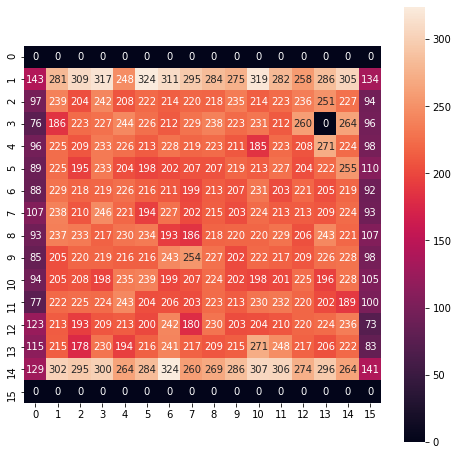

In [52]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(img.reshape(16,16), square=True, annot=True, fmt='d', ax=ax)